In [10]:
import numpy as np
import glob
import pandas as pd

This supposes you have run the code in the scripts/slurm section with the following command (remember to replace the path):
```bash
sbatch bannane/scripts/slurm/slurm_run.slurm
```

In [11]:
slurm_output_path = "../../../LABS/REFINEMENT"
files = glob.glob(slurm_output_path + "/*")
extrapolation_predictions = glob.glob(slurm_output_path + "/valid*.csv")
sorted(extrapolation_predictions)

['../../../LABS/REFINEMENT/valid_data_all_0_05.csv',
 '../../../LABS/REFINEMENT/valid_data_all_0_1.csv',
 '../../../LABS/REFINEMENT/valid_data_all_0_2.csv',
 '../../../LABS/REFINEMENT/valid_data_all_0_3.csv',
 '../../../LABS/REFINEMENT/valid_data_all_0_4.csv',
 '../../../LABS/REFINEMENT/valid_data_all_0_5.csv',
 '../../../LABS/REFINEMENT/valid_data_all_0_6.csv',
 '../../../LABS/REFINEMENT/valid_data_all_0_7.csv',
 '../../../LABS/REFINEMENT/valid_data_all_0_8.csv',
 '../../../LABS/REFINEMENT/valid_data_all_0_9.csv',
 '../../../LABS/REFINEMENT/valid_data_all_0_99.csv']

In [12]:
pred_dfs = []
for file in extrapolation_predictions:
    num_frac = file.split("all_")[-1].split(".csv")[0].replace("_", ".")
    num_frac = float(num_frac)
    df = pd.read_csv(file)
    df["num_frac"] = [num_frac] * len(df)
    pred_dfs.append(df)

all_extrapolation_predictions = pd.concat(pred_dfs)

In [ ]:
def get_metrics(num_frac):
    metrics = {
        "N": [],
        "len": [],
        "emax": [],
        "rmse_eb": [],
        "rmse_rch": [],
        "mape_eb": [],
        "mape_rch": [],
        "unc_eb": [],
        "unc_rch": []
    }
    all_n_df = all_extrapolation_predictions[all_extrapolation_predictions["num_frac"] == num_frac]
    print(all_n_df.columns)
    emaxs = all_n_df["emax"].unique()
    for emax in emaxs:
        emax_df = all_n_df[all_n_df["emax"] == emax]
        for n in emax_df["N"].unique():
            ndf = emax_df[emax_df["N"] == n]
            metrics["N"].append(n)
            metrics["emax"].append(emax)
            metrics["len"].append(len(ndf))
            preds_eb = ndf["eb_pred"].values
            preds_rch = ndf["r_pred"].values
            true_eb = ndf["Energy ket"].values
            true_rch = ndf["Rch"].values
            metrics["rmse_eb"].append(np.sqrt(np.mean((preds_eb - true_eb) ** 2)))
            metrics["rmse_rch"].append(np.sqrt(np.mean((preds_rch - true_rch) ** 2)))
            metrics["mape_eb"].append(np.mean(np.abs((preds_eb - true_eb) / true_eb)) * 100)
            metrics["mape_rch"].append(np.mean(np.abs((preds_rch - true_rch) / true_rch)) * 100)
            # Compute the uncertainty on the error by bootstrapping with the uncertainty
            # in the predictions
            n_samples = 1000
            eb_unc = []
            rch_unc = []
            for i in range(n_samples):
                idx = np.random.choice(len(ndf), len(ndf), replace=True)
                eb_unc.append(np.std(ndf["eb_pred"].values[idx]))
                rch_unc.append(np.std(ndf["r_pred"].values[idx]))
            metrics["unc_eb"].append(np.mean(eb_unc))
            metrics["unc_rch"].append(np.mean(rch_unc))


    return pd.DataFrame(metrics)


In [44]:
TOTAL_SAMPLES = len(pd.read_csv("../../../LABS/REFINEMENT/valid_data_all_0_1.csv"))
TOTAL_SAMPLES / 0.9

4953.333333333333

In [34]:
def average_per_perc(metrics_df):
    avg_eb = metrics_df["mape_eb"].mean()
    avg_rch = metrics_df["mape_rch"].mean()
    return avg_eb, avg_rch

In [35]:
average_per_perc(get_metrics(0.1))

Index(['Sample', 'emax', 'Ct1S0pp', 'Ct1S0np', 'Ct1S0nn', 'Ct3S1', 'C1S0',
       'C3P0', 'C1P1', 'C3P1', 'C3S1', 'CE1', 'C3P2', 'c1', 'c2', 'c3', 'c4',
       'cD', 'cE', 'Nucl bra', 'J bra', 'P bra', 'n bra', 'Energy bra',
       'Nucl ket', 'J ket', 'P ket', 'n ket', 'Energy ket', 'Zero', 'One',
       'Two', 'Rch', 'Z', 'N', 'eb_pred', 'r_pred', 'eb_unc', 'r_unc',
       'num_frac'],
      dtype='object')


(1.6511752356327905, 1.238957408997295)

In [36]:
convergence_df = {"num_frac": [], "mape_eb": [], "mape_rch": []}
for perc in sorted(all_extrapolation_predictions.num_frac.unique()):
    perc_df = all_extrapolation_predictions[all_extrapolation_predictions["num_frac"] == perc]
    try:
        metrics = get_metrics(perc)
        print(perc, average_per_perc(metrics))
        convergence_df["num_frac"].append(perc)
        convergence_df["mape_eb"].append(average_per_perc(metrics)[0])
        convergence_df["mape_rch"].append(average_per_perc(metrics)[1])
    except:
        print("Failed for ", perc)
        continue


Index(['Sample', 'emax', 'Ct1S0pp', 'Ct1S0np', 'Ct1S0nn', 'Ct3S1', 'C1S0',
       'C3P0', 'C1P1', 'C3P1', 'C3S1', 'CE1', 'C3P2', 'c1', 'c2', 'c3', 'c4',
       'cD', 'cE', 'Nucl bra', 'J bra', 'P bra', 'n bra', 'Energy bra',
       'Nucl ket', 'J ket', 'P ket', 'n ket', 'Energy ket', 'Zero', 'One',
       'Two', 'Rch', 'Z', 'N', 'eb_pred', 'r_pred', 'eb_unc', 'r_unc',
       'num_frac'],
      dtype='object')
0.05 (2.3775298681580304, 1.6734448172545664)
Index(['Sample', 'emax', 'Ct1S0pp', 'Ct1S0np', 'Ct1S0nn', 'Ct3S1', 'C1S0',
       'C3P0', 'C1P1', 'C3P1', 'C3S1', 'CE1', 'C3P2', 'c1', 'c2', 'c3', 'c4',
       'cD', 'cE', 'Nucl bra', 'J bra', 'P bra', 'n bra', 'Energy bra',
       'Nucl ket', 'J ket', 'P ket', 'n ket', 'Energy ket', 'Zero', 'One',
       'Two', 'Rch', 'Z', 'N', 'eb_pred', 'r_pred', 'eb_unc', 'r_unc',
       'num_frac'],
      dtype='object')
0.1 (1.6511752356327905, 1.238957408997295)
Index(['Sample', 'emax', 'Ct1S0pp', 'Ct1S0np', 'Ct1S0nn', 'Ct3S1', 'C1S0',
       'C

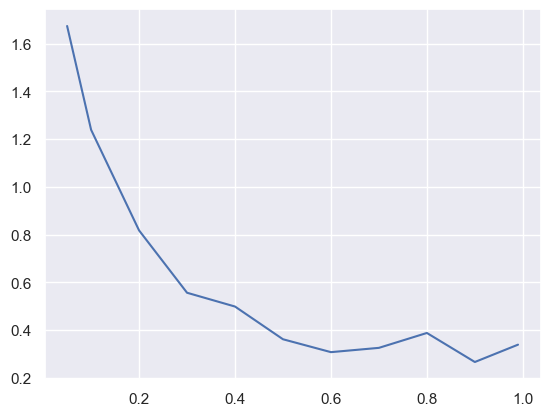

In [37]:
# plot convergence
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fig, ax = plt.subplots()
ax.plot(convergence_df["num_frac"], convergence_df["mape_rch"], label="Energy ket")

In [39]:
pd.DataFrame(convergence_df)

,num_frac,mape_eb,mape_rch
0,0.05,2.377530,1.673445
1,0.10,1.651175,1.238957
2,0.20,1.324699,0.817632
3,0.30,1.515307,0.556681
4,0.40,1.130620,0.498916
5,0.50,1.162365,0.361961
6,0.60,2.192711,0.307988
7,0.70,0.649823,0.325957
8,0.80,0.734317,0.388314
9,0.90,0.570653,0.266722
